# Part 1: Data Preparation

In [1]:
### Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading the datasets
oct_df = pd.read_csv('/data/CausalTrial/2019-Oct.csv')  # Update the path to your October dataset
nov_df = pd.read_csv('/data/CausalTrial/2019-Nov.csv')  # Update the path to your November dataset


In [4]:
# Combine the data
df = pd.concat([oct_df, nov_df])

In [5]:
del(oct_df)
del(nov_df)

In [6]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [7]:
### Replacing nan values to drop
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [8]:
df.dropna(inplace=True)

In [9]:
df.isnull().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

In [10]:
# Step 1: Filter the dataset to include only purchase events
df['is_purchase'] = df['event_type'].apply(lambda x: 1 if x == 'purchase' else 0)

In [12]:
df['event_time'] = pd.to_datetime(df['event_time'])

In [13]:
### Label Encoding

In [14]:
from sklearn.preprocessing import LabelEncoder


In [15]:
label_encoders = {}
categorical_columns = ['category_code', 'brand', 'user_id', 'user_session']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [16]:
### Categorising the price in to 4 groups
df['price_category'] = pd.qcut(df['price'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])


In [17]:
# Calculate the median price for each price category
median_prices = df.groupby('price_category')['price'].median()

In [18]:
# Map the median price back to the original DataFrame
df['median_price'] = df['price_category'].map(median_prices)

In [21]:
df['median_price'] = df['median_price'].astype('int64')

In [22]:
# Create the treatment variable based on the median price
df['treatment'] = (df['price'] < df['median_price']).astype(int)

In [23]:
# Drop the auxiliary median_price column which is not needed anymore
df.drop(columns=['median_price'], inplace=True)

In [30]:
# Define a treatment period threshold (our case taken after 15 days)
treatment_start_date = pd.to_datetime('2019-10-15').date()
treatment_start_date

datetime.date(2019, 10, 15)

In [31]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,price_category,treatment
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,30,104,33.20,2282835,9178894,0,Low,1
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,72,1057,251.74,2063491,7767208,0,High,1
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,100,102,1081.98,1450488,12388987,0,VeryHigh,0
5,2019-10-01 00:00:05+00:00,view,1480613,2053013561092866779,70,1477,908.62,91792,812395,0,VeryHigh,0
8,2019-10-01 00:00:10+00:00,view,28719074,2053013565480109009,15,184,102.71,890648,10730819,0,Low,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68650184 entries, 1 to 67501978
Data columns (total 12 columns):
 #   Column          Dtype              
---  ------          -----              
 0   event_time      datetime64[ns, UTC]
 1   event_type      object             
 2   product_id      int64              
 3   category_id     int64              
 4   category_code   int64              
 5   brand           int64              
 6   price           float64            
 7   user_id         int64              
 8   user_session    int64              
 9   is_purchase     int64              
 10  price_category  category           
 11  treatment       int64              
dtypes: category(1), datetime64[ns, UTC](1), float64(1), int64(8), object(1)
memory usage: 6.2+ GB


In [32]:
df['event_time'] = pd.to_datetime(df['event_time'] ).dt.date

In [33]:
# Create a pre-post variable (1 for post-treatment, 0 for pre-treatment)
df['post_treatment'] = (df['event_time'] >= treatment_start_date).astype(int)

In [34]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,price_category,treatment,post_treatment
1,2019-10-01,view,3900821,2053013552326770905,30,104,33.20,2282835,9178894,0,Low,1,0
3,2019-10-01,view,1307067,2053013558920217191,72,1057,251.74,2063491,7767208,0,High,1,0
4,2019-10-01,view,1004237,2053013555631882655,100,102,1081.98,1450488,12388987,0,VeryHigh,0,0
5,2019-10-01,view,1480613,2053013561092866779,70,1477,908.62,91792,812395,0,VeryHigh,0,0
8,2019-10-01,view,28719074,2053013565480109009,15,184,102.71,890648,10730819,0,Low,0,0


In [35]:
# Create the interaction term
df['interaction'] = df['treatment'] * df['post_treatment']

### Model implementation

In [36]:
import statsmodels.api as sm

In [40]:
# Define the independent variables for the DiD model
X = df[['treatment']]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Define the dependent variable (the outcome you're interested in)
y = df['is_purchase']

# Fit the Difference-in-Differences model
did_model = sm.OLS(y, X).fit()

# Display the results
print(did_model.summary())

                            OLS Regression Results                            
Dep. Variable:            is_purchase   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     515.2
Date:                Wed, 04 Sep 2024   Prob (F-statistic):          4.78e-114
Time:                        05:35:12   Log-Likelihood:             4.1853e+07
No. Observations:            68650184   AIC:                        -8.371e+07
Df Residuals:                68650182   BIC:                        -8.371e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0173   2.22e-05    777.787      0.0

In [41]:
did_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            is_purchase   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     515.2
Date:                Wed, 04 Sep 2024   Prob (F-statistic):          4.78e-114
Time:                        05:35:17   Log-Likelihood:             4.1853e+07
No. Observations:            68650184   AIC:                        -8.371e+07
Df Residuals:                68650182   BIC:                        -8.371e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0173   2.22e-05    777.787      0.000       0.017       0.017
treatment      0.0007   3.18e-05     22.697      0.000       0.001       0.001
==============================================================================
Omnibus:                 86675796.580   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       8294117234.770
Skew:                           7.336   Prob(JB):                         0.00
Kurtosis:                      54.811   Cond. No.                         2.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- initial run is performed, with only treatment and is_purchase variable being used.
- The result is not good, which we know. 
- The data is too huge with varied price ranges. We have splitted data based on the price group people. 
- Its assumed that we will think of high price group users range

In [49]:
## Filtering out only the High priced users
cat_df = df[df['price_category']== 'High']

In [50]:
cat_df.shape

(17108809, 14)

In [51]:
cat_df.is_purchase.unique()

array([0, 1])

In [52]:
purchase_data = cat_df[cat_df['is_purchase'] == 1]
view_data = cat_df[cat_df['is_purchase'] == 0]

In [53]:
purchase_data.shape

(314489, 14)

In [54]:
view_data.shape

(16794320, 14)

In [56]:
from sklearn.utils import resample

In [58]:
### Balancing the data because we have lot of data not purchase than the purchased ones
view_data_balanced = resample(view_data,
                             replace=False,
                              n_samples=len(purchase_data),
                              random_state=42
                             )

In [59]:
balanced_data = pd.concat([purchase_data, view_data_balanced])

In [60]:
balanced_data.shape

(628978, 14)

In [61]:
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [62]:
balanced_data.shape

(628978, 14)

In [64]:
# Define the independent variables for the DiD model
X = balanced_data[['treatment', 'post_treatment','interaction']]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Define the dependent variable (the outcome you're interested in)
y = balanced_data['is_purchase']

# Fit the Difference-in-Differences model
did_model = sm.OLS(y, X).fit()

# Display the results
print(did_model.summary())

                            OLS Regression Results                            
Dep. Variable:            is_purchase   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1856.
Date:                Wed, 04 Sep 2024   Prob (F-statistic):               0.00
Time:                        05:44:05   Log-Likelihood:            -4.5374e+05
No. Observations:              628978   AIC:                         9.075e+05
Df Residuals:                  628974   BIC:                         9.075e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5116      0.002    237.

In [65]:
purchase_data = df[df['is_purchase'] == 1]
view_data = df[df['is_purchase'] == 0]

In [66]:
purchase_data.shape

(1208763, 14)

In [67]:
view_data.shape

(67441421, 14)

In [68]:
view_data_balanced = resample(view_data,
                             replace=False,
                              n_samples=len(purchase_data),
                              random_state=42
                             )

In [69]:
balanced_data = pd.concat([purchase_data, view_data_balanced])

In [70]:
balanced_data.shape

(2417526, 14)

In [74]:
price_category_mapping = {
    'Low':0,
    'Medium':1,
    'High':2,
    'VeryHigh':3
}

In [75]:
balanced_data['price_category_num'] = balanced_data['price_category'].map(price_category_mapping)

In [76]:
balanced_data['price_category_num'].value_counts()

1    674179
2    615728
3    610984
0    516635
Name: price_category_num, dtype: int64

In [77]:
balanced_data.head(1)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,price_category,treatment,post_treatment,interaction,price_category_num
162,2019-10-01,purchase,1004856,2053013555631882655,100,1585,130.76,1745658,8077710,1,Medium,1,0,0,1


In [80]:
# Define the independent variables for the DiD model
X = balanced_data[['treatment', 'post_treatment','interaction','price_category_num','category_code','brand']]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Define the dependent variable (the outcome you're interested in)
y = balanced_data['is_purchase']

# Fit the Difference-in-Differences model
did_model = sm.OLS(y, X).fit()

# Display the results
print(did_model.summary())

                            OLS Regression Results                            
Dep. Variable:            is_purchase   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                 1.019e+04
Date:                Wed, 04 Sep 2024   Prob (F-statistic):               0.00
Time:                        05:51:07   Log-Likelihood:            -1.7244e+06
No. Observations:             2417526   AIC:                         3.449e+06
Df Residuals:                 2417519   BIC:                         3.449e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3265      0

In [81]:
## Veryhigh group

In [82]:
highcat_df = balanced_data[balanced_data['price_category_num']==3]

In [107]:
highcat_df.head(1)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,price_category,treatment,post_treatment,interaction,price_category_num
308,2019-10-01,purchase,1002532,2053013555631882655,100,102,642.69,2119868,3770991,1,VeryHigh,1,0,0,3


In [84]:
highcat_df.is_purchase.value_counts()

1    309503
0    301481
Name: is_purchase, dtype: int64

In [109]:
# Define the independent variables for the DiD model
X = highcat_df[['treatment', 'post_treatment','interaction','product_id','category_code','brand','price']]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Define the dependent variable (the outcome you're interested in)
y = highcat_df['is_purchase']

# Fit the Difference-in-Differences model
did_model_vh = sm.OLS(y, X).fit()

# Display the results
print(did_model_vh.summary())

                            OLS Regression Results                            
Dep. Variable:            is_purchase   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     6352.
Date:                Wed, 04 Sep 2024   Prob (F-statistic):               0.00
Time:                        06:07:45   Log-Likelihood:            -4.2194e+05
No. Observations:              610984   AIC:                         8.439e+05
Df Residuals:                  610976   BIC:                         8.440e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2649      0.005     50.

In [110]:
did_model_vh.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            is_purchase   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     6352.
Date:                Wed, 04 Sep 2024   Prob (F-statistic):               0.00
Time:                        06:07:51   Log-Likelihood:            -4.2194e+05
No. Observations:              610984   AIC:                         8.439e+05
Df Residuals:                  610976   BIC:                         8.440e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2649      0.005     50.398      0.000       0.255       0.275
treatment         -0.0159      0.003     -4.924      0.000      -0.022      -0.010
post_treatment    -0.0312      0.002    -14.041      0.000      -0.036      -0.027
interaction       -0.0104      0.003     -3.237      0.001      -0.017      -0.004
product_id     -4.469e-09   9.02e-11    -49.535      0.000   -4.65e-09   -4.29e-09
category_code      0.0047   3.95e-05    120.089      0.000       0.005       0.005
brand             -0.0001   1.01e-06   -130.316      0.000      -0.000      -0.000
price          -9.312e-05   2.45e-06    -38.035      0.000   -9.79e-05   -8.83e-05
==============================================================================
Omnibus:                  2522380.345   Durbin-Watson:                   0.134
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            77178.988
Skew:                          -0.053   Prob(JB):                         0.00
Kurtosis:                       1.262   Cond. No.                     6.95e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.95e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Very high group has good r2 value
- data is clearly explaining the factors influencing
- Still we are interested in which category/brand of product has positive impact
- Because not all the product brand of high price might create positive impact, we need to look for the brand when price reduced create a positive impact

In [89]:
hghcat_df = balanced_data[balanced_data['price_category_num']==2]

In [100]:
# Define the independent variables for the DiD model
X = hghcat_df[['treatment', 'post_treatment','category_code','brand']]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Define the dependent variable (the outcome you're interested in)
y = hghcat_df['is_purchase']

# Fit the Difference-in-Differences model
did_model_h = sm.OLS(y, X).fit()

# Display the results
print(did_model_h.summary())

                            OLS Regression Results                            
Dep. Variable:            is_purchase   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     3767.
Date:                Wed, 04 Sep 2024   Prob (F-statistic):               0.00
Time:                        06:04:42   Log-Likelihood:            -4.3930e+05
No. Observations:              615728   AIC:                         8.786e+05
Df Residuals:                  615723   BIC:                         8.787e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3012      0.003    100.

In [92]:
medcat_df = balanced_data[balanced_data['price_category_num']==1]

In [101]:
medcat_df.head(1)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,price_category,treatment,post_treatment,interaction,price_category_num
162,2019-10-01,purchase,1004856,2053013555631882655,100,1585,130.76,1745658,8077710,1,Medium,1,0,0,1


In [105]:
# Define the independent variables for the DiD model
X = medcat_df[['treatment', 'post_treatment','interaction','product_id','category_code','brand','price']]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Define the dependent variable (the outcome you're interested in)
y = medcat_df['is_purchase']

# Fit the Difference-in-Differences model
did_model_m = sm.OLS(y, X).fit()

# Display the results
print(did_model_m.summary())

                            OLS Regression Results                            
Dep. Variable:            is_purchase   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     3713.
Date:                Wed, 04 Sep 2024   Prob (F-statistic):               0.00
Time:                        06:06:17   Log-Likelihood:            -4.7287e+05
No. Observations:              674179   AIC:                         9.458e+05
Df Residuals:                  674171   BIC:                         9.458e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7116      0.008     91.

In [106]:
did_model_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            is_purchase   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     3713.
Date:                Wed, 04 Sep 2024   Prob (F-statistic):               0.00
Time:                        06:06:37   Log-Likelihood:            -4.7287e+05
No. Observations:              674179   AIC:                         9.458e+05
Df Residuals:                  674171   BIC:                         9.458e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7116      0.008     91.152      0.000       0.696       0.727
treatment         -0.0988      0.003    -28.711      0.000      -0.106      -0.092
post_treatment    -0.0477      0.002    -22.543      0.000      -0.052      -0.044
interaction        0.0254      0.003      8.256      0.000       0.019       0.031
product_id     -5.399e-09   6.65e-11    -81.147      0.000   -5.53e-09   -5.27e-09
category_code      0.0026   2.65e-05     99.109      0.000       0.003       0.003
brand           2.745e-06   1.01e-06      2.705      0.007    7.56e-07    4.73e-06
price             -0.0019   4.09e-05    -45.805      0.000      -0.002      -0.002
==============================================================================
Omnibus:                  2610526.721   Durbin-Watson:                   0.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            97604.357
Skew:                          -0.219   Prob(JB):                         0.00
Kurtosis:                       1.188   Cond. No.                     1.42e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [95]:
lowcat_df = balanced_data[balanced_data['price_category_num']==0]

In [96]:
# Define the independent variables for the DiD model
X = lowcat_df[['treatment', 'post_treatment','interaction','price_category_num','category_code','brand']]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Define the dependent variable (the outcome you're interested in)
y = lowcat_df['is_purchase']

# Fit the Difference-in-Differences model
did_model_l = sm.OLS(y, X).fit()

# Display the results
print(did_model_l.summary())

                            OLS Regression Results                            
Dep. Variable:            is_purchase   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     988.6
Date:                Wed, 04 Sep 2024   Prob (F-statistic):               0.00
Time:                        05:58:50   Log-Likelihood:            -3.6425e+05
No. Observations:              516635   AIC:                         7.285e+05
Df Residuals:                  516629   BIC:                         7.286e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3372      0

In [115]:
did_model_l.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            is_purchase   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     988.6
Date:                Wed, 04 Sep 2024   Prob (F-statistic):               0.00
Time:                        06:12:55   Log-Likelihood:            -3.6425e+05
No. Observations:              516635   AIC:                         7.285e+05
Df Residuals:                  516629   BIC:                         7.286e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3372      0.003    116.224      0.000       0.331       0.343
treatment              0.0018      0.003      0.569      0.569      -0.004       0.008
post_treatment        -0.0386      0.003    -15.159      0.000      -0.044      -0.034
interaction            0.0024      0.004      0.678      0.498      -0.005       0.009
price_category_num  9.402e-18   8.07e-20    116.461      0.000    9.24e-18    9.56e-18
category_code          0.0011   1.94e-05     58.383      0.000       0.001       0.001
brand               2.885e-05    1.1e-06     26.235      0.000    2.67e-05     3.1e-05
==============================================================================
Omnibus:                  1969742.448   Durbin-Watson:                   0.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            83327.729
Skew:                           0.355   Prob(JB):                         0.00
Kurtosis:                       1.165   Cond. No.                     2.80e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.1e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Visualization

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
# Group data by treatment and post-treatment status
summary_df = highcat_df.groupby(['treatment', 'post_treatment'])['is_purchase'].mean().reset_index()

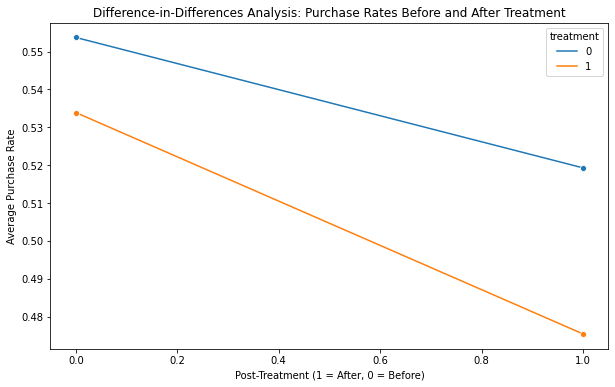

In [113]:
# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=summary_df, x='post_treatment', y='is_purchase', hue='treatment', marker='o')
plt.title('Difference-in-Differences Analysis: Purchase Rates Before and After Treatment')
plt.xlabel('Post-Treatment (1 = After, 0 = Before)')
plt.ylabel('Average Purchase Rate')
plt.show()

### Final Representation

In [116]:
### Some products have positive impact. but because of other categories the numbers are low
### We can notice that interaction column is positive in few price categories.
### Lets list down which product categories have postive impact of price when dicount is given

In [117]:
import statsmodels.api as sm

# Initialize an empty dictionary to store the results for each category
category_results = {}

In [118]:
# Loop through each unique product category
for category in df['category_code'].unique():
    # Subset the data for the current product category
    category_data = df[df['category_code'] == category]
   
    # Define the independent variables for the DiD model
    X = category_data[['treatment', 'post_treatment', 'interaction']]
   
    # Add a constant to the model (intercept)
    X = sm.add_constant(X)
   
    # Define the dependent variable (outcome, e.g., purchase likelihood)
    y = category_data['is_purchase']
   
    # Fit the Difference-in-Differences model for the current category
    did_model = sm.OLS(y, X).fit()
   
    # Store the results for this category
    category_results[category] = did_model


In [119]:
# Initialize an empty list to store categories with a positive interaction
positive_categories = []

In [120]:
# Loop through each category's results and check the interaction term
for category, model in category_results.items():
    interaction_coef = model.params['interaction']
   
    # If the interaction term is positive, add the category to the list
    if interaction_coef > 0:
        positive_categories.append(category)

# Output the list of categories with positive treatment impact
print("Categories with Positive Treatment Impact:", positive_categories)

Categories with Positive Treatment Impact: [30, 100, 15, 104, 45, 93, 12, 29, 75, 83, 99, 69, 79, 102, 38, 36, 51, 119, 96, 33, 127, 61, 42, 0, 74, 84, 46, 95, 76, 80, 123, 110, 97, 71, 5, 109, 64, 39, 48, 65, 25, 60, 40, 105, 17, 90, 49, 114, 62, 63, 126, 81, 24, 108, 115, 88, 7, 124, 120, 13, 52, 22, 3, 8, 86, 9, 56, 6, 37, 85]


In [121]:
df.head(1)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,price_category,treatment,post_treatment,interaction
1,2019-10-01,view,3900821,2053013552326770905,30,104,33.2,2282835,9178894,0,Low,1,0,0


In [128]:
type(positive_categories)

list

In [132]:
df['category_code_orig'] = label_encoders['category_code'].inverse_transform(df['category_code'])
df['brand_orig'] = label_encoders['brand'].inverse_transform(df['brand'])


In [133]:
df_filtered = df[df['category_code'].isin(positive_categories)]

In [134]:
df_filtered.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,price_category,treatment,post_treatment,interaction,category_code_orig,brand_orig
1,2019-10-01,view,3900821,2053013552326770905,30,104,33.20,2282835,9178894,0,Low,1,0,0,appliances.environment.water_heater,aqua
4,2019-10-01,view,1004237,2053013555631882655,100,102,1081.98,1450488,12388987,0,VeryHigh,0,0,0,electronics.smartphone,apple
8,2019-10-01,view,28719074,2053013565480109009,15,184,102.71,890648,10730819,0,Low,0,0,0,apparel.shoes.keds,baden
9,2019-10-01,view,1004545,2053013555631882655,100,835,566.01,1524261,4015085,0,VeryHigh,1,0,0,electronics.smartphone,huawei
11,2019-10-01,view,1005011,2053013555631882655,100,1585,900.64,1272703,5026006,0,VeryHigh,0,0,0,electronics.smartphone,samsung


In [135]:
df_filtered.shape

(51693216, 16)

In [137]:
df_filtered[['category_code_orig','brand_orig']].value_counts().reset_index()

,category_code_orig,brand_orig,0
0,electronics.smartphone,samsung,9095127
1,electronics.smartphone,apple,7931573
2,electronics.smartphone,xiaomi,5532333
3,electronics.smartphone,huawei,2239813
4,electronics.smartphone,oppo,1294585
...,...,...,...
2250,computers.peripherals.mouse,qcyber,1
2251,appliances.kitchen.kettle,sencor,1
2252,construction.tools.screw,milwaukee,1
2253,appliances.environment.vacuum,sencor,1


In [138]:
### Around 2000 categories of product has positive impact on the price reduction

In [139]:
del lowcat_df
del medcat_df
del hghcat_df
del highcat_df
del df

In [141]:
import gc

In [142]:
gc.collect()

1440

### Product impact creation

In [140]:
# Initialize empty dictionaries to store positive impact for categories, brands, etc.
category_impact = {}
brand_impact = {}
product_impact = {}

In [143]:
# Loop through each unique category_code
for category in balanced_data['category_code'].unique():
    category_data = balanced_data[balanced_data['category_code'] == category]
   
    # Define the independent variables for the DiD model
    X = category_data[['treatment', 'post_treatment', 'interaction']]
    X = sm.add_constant(X)
   
    # Define the dependent variable (purchase likelihood)
    y = category_data['is_purchase']
   
    # Fit the DiD model for the current category
    did_model = sm.OLS(y, X).fit()
   
    # Store the interaction term (treatment effect) in the dictionary
    category_impact[category] = did_model.params['interaction']

In [144]:
# Repeat for brand
for brand in balanced_data['brand'].unique():
    brand_data = balanced_data[balanced_data['brand'] == brand]
   
    X = brand_data[['treatment', 'post_treatment', 'interaction']]
    X = sm.add_constant(X)
   
    y = brand_data['is_purchase']
    did_model = sm.OLS(y, X).fit()
   
    brand_impact[brand] = did_model.params['interaction']

In [145]:


# Repeat for product_id
for product in balanced_data['product_id'].unique():
    product_data = balanced_data[balanced_data['product_id'] == product]
   
    X = product_data[['treatment', 'post_treatment', 'interaction']]
    X = sm.add_constant(X)
   
    y = product_data['is_purchase']
    did_model = sm.OLS(y, X).fit()
   
    product_impact[product] = did_model.params['interaction']



In [146]:
# Convert category, brand, product_id impacts to DataFrames for better interpretation
category_impact_df = pd.DataFrame(list(category_impact.items()), columns=['category_code', 'interaction_impact'])
brand_impact_df = pd.DataFrame(list(brand_impact.items()), columns=['brand', 'interaction_impact'])
product_impact_df = pd.DataFrame(list(product_impact.items()), columns=['product_id', 'interaction_impact'])


In [147]:
# Find categories with positive impact
positive_categories = category_impact_df[category_impact_df['interaction_impact'] > 0]
positive_brands = brand_impact_df[brand_impact_df['interaction_impact'] > 0]
positive_products = product_impact_df[product_impact_df['interaction_impact'] > 0]

In [148]:
# Output the positive categories, brands, products
print("Categories with Positive Impact:")
print(positive_categories)

print("Brands with Positive Impact:")
print(positive_brands)

print("Products with Positive Impact:")
print(positive_products)

Categories with Positive Impact:
     category_code  interaction_impact
0              100            0.005314
2               93            0.023774
3               27            0.003678
4               61            0.032501
5               72            0.008750
..             ...                 ...
121             19            0.071429
123             90            0.055556
124             86            0.086538
125             85            0.111111
126             37            0.333333

[70 rows x 2 columns]
Brands with Positive Impact:
      brand  interaction_impact
0      1585            0.006262
1       102            0.004351
2      1592            0.033128
3      1341            0.142691
4      1933            0.008355
...     ...                 ...
1363    501            0.200000
1367   1483            0.333333
1368   1586            0.333333
1369   1787            0.062500
1370   1838            0.333333

[681 rows x 2 columns]
Products with Positive Impact:
       p

In [149]:
positive_categories.to_csv('DiD_PositiveCat.csv', index=None)

In [150]:
positive_brands.to_csv('DiD_Positivebrand.csv', index=None)

In [151]:
positive_products.to_csv('DiD_Positiveproduct.csv', index=None)

In [157]:
positive_categories

,category_code,interaction_impact
0,100,0.005314
2,93,0.023774
3,27,0.003678
4,61,0.032501
5,72,0.008750
...,...,...
121,19,0.071429
123,90,0.055556
124,86,0.086538
125,85,0.111111


In [158]:
df_filtered = balanced_data.merge(positive_categories, 
                                  on='category_code', how='inner')

In [159]:
df_filtered.shape

(1943336, 16)

In [160]:
df_filtered['category_code_orig'] = label_encoders['category_code'].inverse_transform(df_filtered['category_code'])
df_filtered['brand_orig'] = label_encoders['brand'].inverse_transform(df_filtered['brand'])


In [161]:
df_filtered.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,price_category,treatment,post_treatment,interaction,price_category_num,interaction_impact,category_code_orig,brand_orig
0,2019-10-01,purchase,1004856,2053013555631882655,100,1585,130.76,1745658,8077710,1,Medium,1,0,0,1,0.005314,electronics.smartphone,samsung
1,2019-10-01,purchase,1002532,2053013555631882655,100,102,642.69,2119868,3770991,1,VeryHigh,1,0,0,3,0.005314,electronics.smartphone,apple
2,2019-10-01,purchase,1002524,2053013555631882655,100,102,515.67,1069473,713175,1,VeryHigh,1,0,0,3,0.005314,electronics.smartphone,apple
3,2019-10-01,purchase,1004932,2053013555631882655,100,1933,463.31,2300189,8220776,1,VeryHigh,1,0,0,3,0.005314,electronics.smartphone,vivo
4,2019-10-01,purchase,1004246,2053013555631882655,100,102,736.18,431419,11462732,1,VeryHigh,1,0,0,3,0.005314,electronics.smartphone,apple


In [156]:
balanced_data[balanced_data.category_code==100]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,price_category,treatment,post_treatment,interaction,price_category_num
162,2019-10-01,purchase,1004856,2053013555631882655,100,1585,130.76,1745658,8077710,1,Medium,1,0,0,1
308,2019-10-01,purchase,1002532,2053013555631882655,100,102,642.69,2119868,3770991,1,VeryHigh,1,0,0,3
618,2019-10-01,purchase,1002524,2053013555631882655,100,102,515.67,1069473,713175,1,VeryHigh,1,0,0,3
860,2019-10-01,purchase,1004932,2053013555631882655,100,1933,463.31,2300189,8220776,1,VeryHigh,1,0,0,3
1558,2019-10-01,purchase,1004246,2053013555631882655,100,102,736.18,431419,11462732,1,VeryHigh,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28066767,2019-10-21,view,1004788,2053013555631882655,100,1996,136.17,1707201,7846346,0,Medium,1,1,1,1
56093033,2019-11-24,view,1005173,2053013555631882655,100,1585,643.23,774622,8589793,0,VeryHigh,1,1,1,3
45978282,2019-11-18,cart,1004767,2053013555631882655,100,1585,246.06,3779857,8264756,0,High,1,1,1,2
29269129,2019-11-15,view,1005105,2053013555631882655,100,102,1364.00,769008,5815012,0,VeryHigh,0,1,0,3


In [163]:
df_filtered[['category_code_orig','brand_orig','price','interaction_impact']].value_counts().reset_index()

,category_code_orig,brand_orig,price,interaction_impact,0
0,electronics.smartphone,samsung,128.42,0.005314,9418
1,electronics.smartphone,samsung,131.53,0.005314,7711
2,electronics.smartphone,samsung,643.23,0.005314,7634
3,electronics.smartphone,apple,916.37,0.005314,6997
4,electronics.smartphone,samsung,130.99,0.005314,6379
...,...,...,...,...,...
64240,appliances.kitchen.oven,hotpoint-ariston,354.17,0.014770,1
64241,appliances.kitchen.oven,hotpoint-ariston,367.71,0.014770,1
64242,appliances.kitchen.oven,hotpoint-ariston,369.43,0.014770,1
64243,appliances.kitchen.oven,hotpoint-ariston,370.58,0.014770,1


In [166]:
## The above listed product are the list of products which have positive impact.
## Eg. Smartphone.samsung has positive imapct of 0.005,
## which means that if price is reduced, the product has chances of sales increase by 5%

In [165]:
df_filtered.groupby(['category_code_orig','brand_orig'])[['price','interaction_impact']].sum().reset_index()

,category_code_orig,brand_orig,price,interaction_impact
0,accessories.bag,a-elita,98.75,0.094889
1,accessories.bag,acer,6362.23,3.155060
2,accessories.bag,acron,64.24,0.094889
3,accessories.bag,amen,1017.76,0.569334
4,accessories.bag,andromeda,28.46,0.023722
...,...,...,...,...
2010,sport.tennis,fly,127.40,0.419643
2011,sport.tennis,head,5522.81,5.203571
2012,sport.tennis,joerex,41.44,0.587500
2013,sport.tennis,stiga,553.40,0.839286


In [167]:
df_filtered.to_csv('df_filtered.csv', index=None)

In [168]:
df_filtered.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,price_category,treatment,post_treatment,interaction,price_category_num,interaction_impact,category_code_orig,brand_orig
0,2019-10-01,purchase,1004856,2053013555631882655,100,1585,130.76,1745658,8077710,1,Medium,1,0,0,1,0.005314,electronics.smartphone,samsung
1,2019-10-01,purchase,1002532,2053013555631882655,100,102,642.69,2119868,3770991,1,VeryHigh,1,0,0,3,0.005314,electronics.smartphone,apple
2,2019-10-01,purchase,1002524,2053013555631882655,100,102,515.67,1069473,713175,1,VeryHigh,1,0,0,3,0.005314,electronics.smartphone,apple
3,2019-10-01,purchase,1004932,2053013555631882655,100,1933,463.31,2300189,8220776,1,VeryHigh,1,0,0,3,0.005314,electronics.smartphone,vivo
4,2019-10-01,purchase,1004246,2053013555631882655,100,102,736.18,431419,11462732,1,VeryHigh,1,0,0,3,0.005314,electronics.smartphone,apple


In [169]:
df_filtered.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session',
       'is_purchase', 'price_category', 'treatment', 'post_treatment',
       'interaction', 'price_category_num', 'interaction_impact',
       'category_code_orig', 'brand_orig'],
      dtype='object')